In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import utils
from whitelists import *
from sorted_crates import *
from top_crates import *
import functools

# Configure pyplot: enlarge plots 
plt.rcParams['figure.figsize'] = [15, 8]
# Configure pandas: show all columns when printing a dataframe
pd.set_option('display.max_columns', None)
# Configure pandas: show more rows when printing a dataframe
pd.set_option('display.min_rows', 20)

In [2]:
# Load tables
function_definitions = utils.load_selected_function_definitions()
raw_function_unsafe_reasons = utils.load_unsafe_reasons_in_function_definitions()
unsafe_block_calls = utils.load_unsafe_block_calls()
const_calls = utils.load_const_calls()
unsafe_blocks = utils.load_unsafe_blocks()
traits = utils.load_selected_traits()
traits_impls = utils.load_selected_impl_definitions()
type_defs = utils.load_selected_type_defs()
adts = utils.load_selected_adts()
adt_field_types = utils.load_selected_adt_field_types()
selected_builds = utils.load_selected_builds()

In [3]:
# Cleanup: remove duplicates
raw_function_unsafe_reasons = raw_function_unsafe_reasons.drop_duplicates()

# Remove functions that are not in function_definitions
raw_function_unsafe_reasons = raw_function_unsafe_reasons[
    raw_function_unsafe_reasons.def_path.isin(set(function_definitions.def_path.unique()))
]

possible_unsafe_reasons = [
    "call to unsafe function",
    "use of inline assembly",
    "initializing type with `rustc_layout_scalar_valid_range` attr",
    "cast of pointer to int",
    "pointer operation",
    "borrow of packed field",
    "use of mutable static",
    "use of extern static",
    "dereference of raw pointer",
    "assignment to non-`Copy` union field",
    "access to union field",
    "mutation of layout constrained field",
    "borrow of layout constrained field with interior mutability",
]

# Map reasons -> number
function_unsafe_reasons = raw_function_unsafe_reasons[
    ["crate_name", "crate_hash", "def_path", "unsafe_reason"]
].groupby("def_path").agg(frozenset).rename(
    columns={'unsafe_reason': 'unsafe_reasons'}
)

function_unsafe_reasons["unsafe_reasons_vec"] = function_unsafe_reasons.unsafe_reasons.map(
    lambda x: [reason in x for reason in possible_unsafe_reasons]
)
function_unsafe_reasons["num_unsafe_reasons"] = function_unsafe_reasons.unsafe_reasons_vec.map(sum)

for reason in possible_unsafe_reasons:
    function_unsafe_reasons[reason] = function_unsafe_reasons.unsafe_reasons.map(
        lambda x: reason in x
    )

# Augment const calls made from unsafe blocks
unsafe_block_const_calls = unsafe_block_calls.join(
    const_calls.set_index("call"),
    on="call",
    how="inner",
    rsuffix="_defsite",
)
# Rename confusing columns
unsafe_block_const_calls.rename(
    columns={"crate_name": "crate_callsite", "crate": "crate_defsite"},
    inplace=True
)
const_calls.rename(
    columns={"crate_name": "crate_callsite", "crate": "crate_defsite"},
    inplace=True
)

# Preprocessing
crates = pd.DataFrame({
    "crate": selected_builds.crate,
    "crate_hash": selected_builds.crate_hash,
    "package": selected_builds.package.map(lambda x: str(x).lower().replace("-", "_")),
})
user_written_unsafe_blocks = unsafe_blocks[unsafe_blocks.check_mode == "UnsafeBlockUserProvided"]
unsafe_function_definitions = function_definitions[function_definitions.unsafety == "Unsafe"]
unsafe_traits = traits[traits.unsafety == "Unsafe"]
unsafe_traits_impls = traits_impls[traits_impls.unsafety == "Unsafe"]

In [4]:
# Whitelists
all_function_names = set(function_definitions.def_path.unique())
unchecked_function_names = get_unchecked_function_names(all_function_names)
unguarded_function_names = get_unguarded_function_names(all_function_names)

In [5]:
# Calls
all_calls = utils.load_all_calls()
unsafe_calls = all_calls.query("unsafety != 'Normal'")
assert len(pd.unique(unsafe_calls.unsafety)) == 1

In [6]:
### Filter by user-written unsafe code
user_written_unsafe_const_calls = const_calls[
    const_calls.check_mode == "UnsafeBlockUserProvided"
]

slice_call = []
for x in user_written_unsafe_const_calls.def_path.unique():
    if x.endswith('slice::raw::from_raw_parts'):
        slice_call.append(x)
        break

parts = slice_call[0].split("[")
core_hash = parts[1].split("]")[0]
core_hash

'9834'

In [7]:
# Top X Crates
def norm(x):
    return x.lower().replace("-", "_")

top_250_compiling_crates = set(map(norm, sorted_crates[:250])) & set(map(norm, selected_builds.package.unique()))
top_250_crates_set = set(sorted_crates[:250])
top_250_mask = selected_builds.package.map(lambda x: x.replace("-", "_") in top_250_crates_set)
top_250_builds = selected_builds[top_250_mask][
    ~selected_builds[top_250_mask]["package"].duplicated()
]
top_500_compiling_crates = set(map(norm, sorted_crates[:500])) & set(map(norm, selected_builds.package.unique()))
top_500_crates_set = set(sorted_crates[:500])
top_500_mask = selected_builds.package.map(lambda x: x.replace("-", "_") in top_500_crates_set)
top_500_builds = selected_builds[top_500_mask][
    ~selected_builds[top_500_mask]["package"].duplicated()
]
top_1000_compiling_crates = set(map(norm, sorted_crates[:1000])) & set(map(norm, selected_builds.package.unique()))
top_1000_crates_set = set(sorted_crates[:1000])
top_1000_mask = selected_builds.package.map(lambda x: x.replace("-", "_") in top_1000_crates_set)
top_1000_builds = selected_builds[top_1000_mask][
    ~selected_builds[top_1000_mask]["package"].duplicated()
]

In [8]:
print("Number of compiling crates in top 250:\t", len(top_250_compiling_crates))
print("Number of builds in top 250:\t\t", len(top_250_builds))
print("Number of expected crates in top 250:\t", len(sorted_crates[:250]))

Number of compiling crates in top 250:	 250
Number of builds in top 250:		 250
Number of expected crates in top 250:	 250


In [9]:
print("Number of compiling crates in top 500:\t", len(top_500_compiling_crates))
print("Number of builds in top 500:\t\t", len(top_500_builds))
print("Number of expected crates in top 500:\t", len(sorted_crates[:500]))

Number of compiling crates in top 500:	 497
Number of builds in top 500:		 497
Number of expected crates in top 500:	 500


In [10]:
print("Number of compiling crates in top 1000:\t", len(top_1000_compiling_crates))
print("Number of builds in top 1000:\t\t", len(top_1000_builds))
print("Number of expected crates in top 1000:\t", len(sorted_crates[:1000]))

Number of compiling crates in top 1000:	 973
Number of builds in top 1000:		 973
Number of expected crates in top 1000:	 1000


In [11]:
print("Number of selected builds:\t", len(selected_builds))
print("Number of crates total:\t\t", len(crates))

Number of selected builds:	 4889
Number of crates total:		 4889


------top 250------
Rust           1243
ForeignItem    1167
C                47
Name: abi, dtype: int64

Percents:
Rust           50.590151
ForeignItem    47.496947
C               1.912902
Name: abi, dtype: float64

Unsafe function definitions: 2457


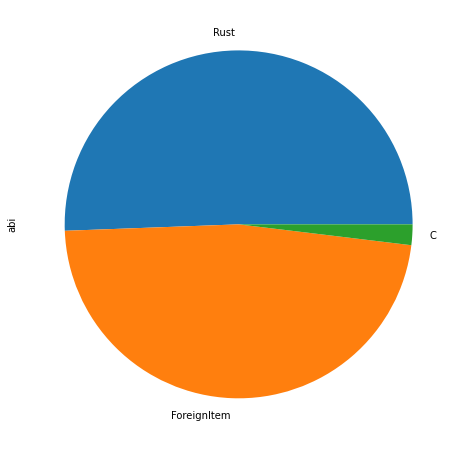

In [12]:
# Frequency of abi DEFINITIONS
top_unsafe_defs = unsafe_function_definitions[
    unsafe_function_definitions.crate.isin(top_250_builds.crate) #sorted_crates[:250])
]
values = top_unsafe_defs.abi.value_counts()

print("------top 250------")
print(values)
print()
print("Percents:")
print(values / len(top_unsafe_defs) * 100)
print()
print("Unsafe function definitions:", len(top_unsafe_defs))
values.plot.pie()

del values, top_unsafe_defs

------top 500------
Rust           3245
ForeignItem    2567
C               176
Name: abi, dtype: int64

Percents:
Rust           54.191717
ForeignItem    42.869071
C               2.939212
Name: abi, dtype: float64

Unsafe function definitions: 5988


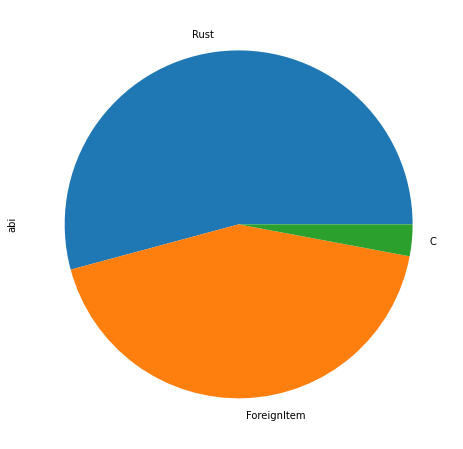

In [13]:
# Frequency of abi DEFINITIONS
top_unsafe_defs = unsafe_function_definitions[
    unsafe_function_definitions.crate.isin(top_500_builds.crate)
]
values = top_unsafe_defs.abi.value_counts()

print("------top 500------")
print(values)
print()
print("Percents:")
print(values / len(top_unsafe_defs) * 100)
print()
print("Unsafe function definitions:", len(top_unsafe_defs))
values.plot.pie()

del values, top_unsafe_defs

------top 1000------
ForeignItem    9300
Rust           7783
C               262
sysv64            2
Name: abi, dtype: int64

Percents:
ForeignItem    53.611575
Rust           44.866548
C               1.510348
sysv64          0.011529
Name: abi, dtype: float64

Unsafe function definitions: 17347


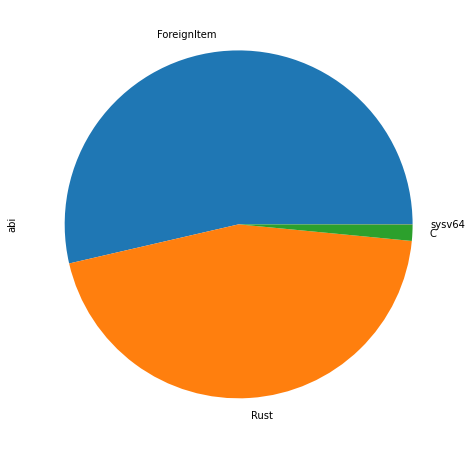

In [14]:
# Frequency of abi DEFINITIONS
top_unsafe_defs = unsafe_function_definitions[
    unsafe_function_definitions.crate.isin(top_1000_builds.crate)
]
values = top_unsafe_defs.abi.value_counts()

print("------top 1000------")
print(values)
print()
print("Percents:")
print(values / len(top_unsafe_defs) * 100)
print()
print("Unsafe function definitions:", len(top_unsafe_defs))
values.plot.pie()

del values, top_unsafe_defs

------total------
ForeignItem    52440
Rust           42520
C               3110
system             2
sysv64             2
efiapi             1
Name: abi, dtype: int64

Percents:
ForeignItem    53.469284
Rust           43.354576
C               3.171043
system          0.002039
sysv64          0.002039
efiapi          0.001020
Name: abi, dtype: float64

Unsafe function definitions: 98075


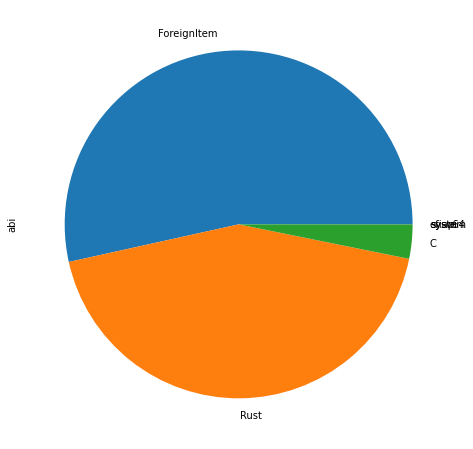

In [15]:
# Frequency of abi DEFINITIONS

values = unsafe_function_definitions.abi.value_counts()

print("------total------")
print(values)
print()
print("Percents:")
print(values / len(unsafe_function_definitions) * 100)
print()
print("Unsafe function definitions:", len(unsafe_function_definitions))
values.plot.pie()

del values

In [16]:
# Which crates define unsafe Rust functions?
def_unsafe_rust_funcs = unsafe_function_definitions[
    unsafe_function_definitions.abi == "Rust"
]

print("------top 250------")
def_urust = def_unsafe_rust_funcs[
    def_unsafe_rust_funcs.crate.isin(top_250_builds.crate)
]
values = def_urust.crate.value_counts()
print("Number of crates that define unsafe Rust functions:\t", len(values))
print("Top 20 crates with most defined unsafe Rust functions:")
print()
print(values[:20])
del values, def_urust

print("------top 500------")
def_urust = def_unsafe_rust_funcs[
    def_unsafe_rust_funcs.crate.isin(top_500_builds.crate)
]
values = def_urust.crate.value_counts()
print("Number of crates that define unsafe Rust functions:\t", len(values))
print("Top 20 crates with most defined unsafe Rust functions:")
print()
print(values[:20])
del values, def_urust

print("------top 1000------")
def_urust = def_unsafe_rust_funcs[
    def_unsafe_rust_funcs.crate.isin(top_1000_builds.crate)
]
values = def_urust.crate.value_counts()
print("Number of crates that define unsafe Rust functions:\t", len(values))
print("Top 20 crates with most defined unsafe Rust functions:")
print()
print(values[:20])
del values, def_urust

print("------total------")
values = def_unsafe_rust_funcs.crate.value_counts()
print("Number of crates that define unsafe Rust functions:\t", len(values))
print("Top 20 crates with most defined unsafe Rust functions:")
print()
print(values[:20])
del values

------top 250------
Number of crates that define unsafe Rust functions:	 93
Top 20 crates with most defined unsafe Rust functions:

futures_util        135
openssl              80
cloudabi             66
core_foundation      58
tokio                54
wasi                 45
aho_corasick         41
nix                  37
syscall              35
hashbrown            34
bytes                34
rayon_core           33
crossbeam_epoch      28
parking_lot          27
memchr               26
ppv_lite86           25
hyper                25
lock_api             23
parking_lot_core     21
futures_task         20
Name: crate, dtype: int64
------top 500------
Number of crates that define unsafe Rust functions:	 155
Top 20 crates with most defined unsafe Rust functions:

js_sys             803
clang_sys          349
web_sys            158
futures_util       135
git2               108
openssl             80
blake2b_simd        77
wasm_bindgen        74
cloudabi            66
core_foundation     58

In [17]:
# Which crates define C functions?
def_c_funcs = unsafe_function_definitions[
    unsafe_function_definitions.abi == "C"
]
values = def_c_funcs.crate.value_counts()

print("------top 250------")
def_c = def_c_funcs[
    def_c_funcs.crate.isin(top_250_builds.crate)
]
vals = def_c.crate.value_counts()
print("Number of crates that define C functions:\t", len(vals))
print("Top 20 crates with most defined C functions:")
print()
print(vals[:20])
print()
del vals, def_c

print("------top 500------")
def_c = def_c_funcs[
    def_c_funcs.crate.isin(top_500_builds.crate)
]
vals = def_c.crate.value_counts()
print("Number of crates that define C functions:\t", len(vals))
print("Top 20 crates with most defined C functions:")
print()
print(vals[:20])
print()
del vals, def_c

print("------top 1000------")
def_c = def_c_funcs[
    def_c_funcs.crate.isin(top_1000_builds.crate)
]
vals = def_c.crate.value_counts()
print("Number of crates that define C functions:\t", len(vals))
print("Top 20 crates with most defined C functions:")
print()
print(vals[:20])
print()
del vals, def_c

print("------total------")
print("Number of crates that define C functions:\t", len(values))
print("Top 20 crates with most defined C functions:")
print()
print(values[:20])
del values

------top 250------
Number of crates that define C functions:	 4
Top 20 crates with most defined C functions:

libc         27
openssl      18
backtrace     1
ring          1
Name: crate, dtype: int64

------top 500------
Number of crates that define C functions:	 7
Top 20 crates with most defined C functions:

wasm_bindgen          96
miniz_oxide_c_api     31
libc                  27
openssl               18
security_framework     2
backtrace              1
ring                   1
Name: crate, dtype: int64

------top 1000------
Number of crates that define C functions:	 16
Top 20 crates with most defined C functions:

wasm_bindgen           96
glib                   39
miniz_oxide_c_api      31
libc                   27
brotli_decompressor    18
openssl                18
block                  15
compiler_builtins       5
winit                   4
onig                    2
security_framework      2
backtrace               1
ring                    1
secp256k1               1
rusqlite

In [18]:
# Which crates define Foreign Items?
def_fi_funcs = unsafe_function_definitions[
    unsafe_function_definitions.abi == "ForeignItem"
]
values = def_fi_funcs.crate.value_counts()

print("------top 250------")
def_fi = def_fi_funcs[
    def_fi_funcs.crate.isin(top_250_builds.crate)
]
vals = def_fi.crate.value_counts()
print("Number of crates that define Foreign Items:\t", len(vals))
print("Top 20 crates with most defined Foreign Items:")
print()
print(vals[:20])
print()
del vals, def_fi

print("------top 500------")
def_fi = def_fi_funcs[
    def_fi_funcs.crate.isin(top_500_builds.crate)
]
vals = def_fi.crate.value_counts()
print("Number of crates that define Foreign Items:\t", len(vals))
print("Top 20 crates with most defined Foreign Items:")
print()
print(vals[:20])
print()
del vals, def_fi

print("------top 1000------")
def_fi = def_fi_funcs[
    def_fi_funcs.crate.isin(top_1000_builds.crate)
]
vals = def_fi.crate.value_counts()
print("Number of crates that define Foreign Items:\t", len(vals))
print("Top 20 crates with most defined Foreign Items:")
print()
print(vals[:20])
print()
del vals, def_fi

print("------total------")
print("Number of crates that define Foreign Items:\t", len(values))
print("Top 20 crates with most defined Foreign Items:")
print()
print(values[:20])
# crypto sneaks in here again
del values

------top 250------
Number of crates that define Foreign Items:	 8
Top 20 crates with most defined Foreign Items:

libc                   704
core_foundation_sys    232
ring                    74
libz_sys                56
cloudabi                49
wasi                    45
backtrace                4
backtrace_sys            3
Name: crate, dtype: int64

------top 500------
Number of crates that define Foreign Items:	 28
Top 20 crates with most defined Foreign Items:

libc                      704
libgit2_sys               593
libsqlite3_sys            272
core_foundation_sys       232
fuchsia_zircon_sys        139
libssh2_sys                96
ring                       74
security_framework_sys     57
libz_sys                   56
hermit_abi                 55
lzma_sys                   52
cloudabi                   49
wasi                       45
curl_sys                   44
brotli_sys                 23
crypto                     18
termios                    13
miniz_sys       

------top 250------
Rust              4973
C                 1406
rust-intrinsic     268
Name: abi, dtype: int64

Percents: 
Rust              74.815706
C                 21.152400
rust-intrinsic     4.031894
Name: abi, dtype: float64

Unsafe calls: 6647


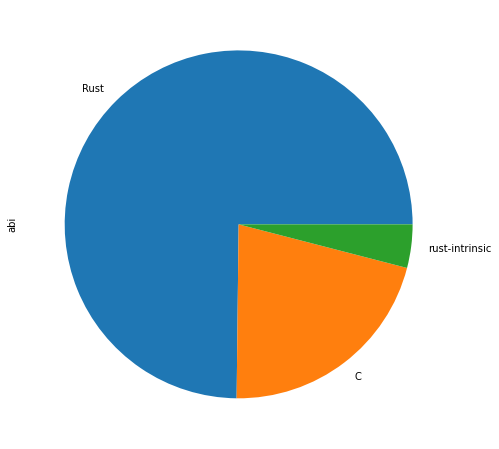

In [19]:
# Frequency of abi CALLS
unsafe_const_calls = const_calls[
    const_calls.unsafety == "Unsafe"
]
unsafe_const_calls_250 = unsafe_const_calls[
    unsafe_const_calls.crate_callsite.isin(top_250_builds.crate)
]
values_250 = unsafe_const_calls_250.abi.value_counts()

print("------top 250------")
print(values_250)
print()
print("Percents: ")
print(values_250 / len(unsafe_const_calls_250) * 100)
print()
print("Unsafe calls:", len(unsafe_const_calls_250))
values_250.plot.pie()

del values_250

------top 500------
Rust              9256
C                 2236
rust-intrinsic     589
Name: abi, dtype: int64

Percents: 
Rust              76.616174
C                 18.508402
rust-intrinsic     4.875424
Name: abi, dtype: float64

Unsafe calls: 12081


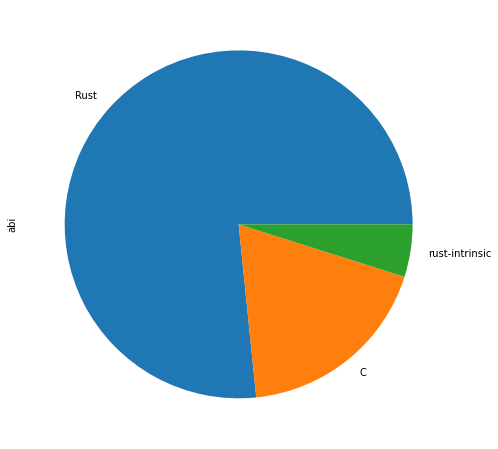

In [20]:
unsafe_const_calls_500 = unsafe_const_calls[
    unsafe_const_calls.crate_callsite.isin(top_500_builds.crate)
]
values_500 = unsafe_const_calls_500.abi.value_counts()

print("------top 500------")
print(values_500)
print()
print("Percents: ")
print(values_500 / len(unsafe_const_calls_500) * 100)
print()
print("Unsafe calls:", len(unsafe_const_calls_500))
values_500.plot.pie()

del values_500

------top 1000------
Rust              17101
C                  5135
rust-intrinsic     4937
sysv64                2
Name: abi, dtype: int64

Percents: 
Rust              62.929163
C                 18.896044
rust-intrinsic    18.167433
sysv64             0.007360
Name: abi, dtype: float64

Unsafe calls: 27175


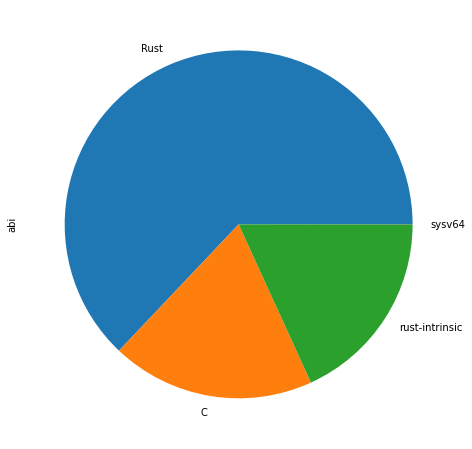

In [21]:
unsafe_const_calls_1000 = unsafe_const_calls[
    unsafe_const_calls.crate_callsite.isin(top_1000_builds.crate)
]
values_1000 = unsafe_const_calls_1000.abi.value_counts()

print("------top 1000------")
print(values_1000)
print()
print("Percents: ")
print(values_1000 / len(unsafe_const_calls_1000) * 100)
print()
print("Unsafe calls:", len(unsafe_const_calls_1000))
values_1000.plot.pie()

del values_1000

------total------
Rust              85834
C                 29124
rust-intrinsic    17647
system              272
sysv64                2
Name: abi, dtype: int64

Percents: 
Rust              64.595610
C                 21.917685
rust-intrinsic    13.280503
system             0.204698
sysv64             0.001505
Name: abi, dtype: float64

Unsafe calls: 132879


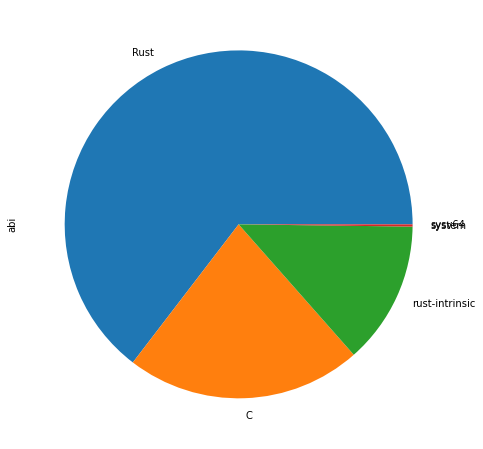

In [22]:
# Frequency of abi CALLS
values = unsafe_const_calls.abi.value_counts()

print("------total------")
print(values)
print()
print("Percents: ")
print(values / len(unsafe_const_calls) * 100)
print()
print("Unsafe calls:", len(unsafe_const_calls))
values.plot.pie()

del values

In [23]:
# Which crates call unsafe Rust functions? - ALL
calls_unsafe_rust_funcs = unsafe_const_calls[
    unsafe_const_calls.abi == "Rust"
]
#values = calls_unsafe_rust_funcs[['crate_callsite', 'package_version']].apply(
#    lambda row: (row['crate_callsite'], row['package_version']), axis=1
#).squeeze().value_counts()

# Filter by user-written blocks
uw_calls_unsafe_rust_funcs = calls_unsafe_rust_funcs[
    calls_unsafe_rust_funcs.check_mode == "UnsafeBlockUserProvided"
]
values_uw = uw_calls_unsafe_rust_funcs[['crate_callsite', 'package_version']].apply(
    lambda row: (row['crate_callsite'], row['package_version']), axis=1
).squeeze().value_counts()

#print(len(values))
#print(len(values_uw))
#print()
#assert(len(values) == len(values_uw))
#del values

print("------top 250------")
uw_urust = uw_calls_unsafe_rust_funcs[
    uw_calls_unsafe_rust_funcs.crate_callsite.isin(top_250_builds.crate)
]
values = uw_urust[['crate_callsite', 'package_version']].apply(
    lambda row: (row['crate_callsite'], row['package_version']), axis=1
).squeeze().value_counts()
print("Number of crates that call unsafe Rust:\t", len(values))
print("Top 20 crates with most unsafe Rust calls:\t")
print()
print(values[:20])
print()
del values

print("------top 500------")
uw_urust = uw_calls_unsafe_rust_funcs[
    uw_calls_unsafe_rust_funcs.crate_callsite.isin(top_500_builds.crate)
]
values = uw_urust[['crate_callsite', 'package_version']].apply(
    lambda row: (row['crate_callsite'], row['package_version']), axis=1
).squeeze().value_counts()
print("Number of crates that call unsafe Rust:\t", len(values))
print("Top 20 crates with most unsafe Rust calls:\t")
print()
print(values[:20])
print()
del values

print("------top 1000------")
uw_urust = uw_calls_unsafe_rust_funcs[
    uw_calls_unsafe_rust_funcs.crate_callsite.isin(top_1000_builds.crate)
]
values = uw_urust[['crate_callsite', 'package_version']].apply(
    lambda row: (row['crate_callsite'], row['package_version']), axis=1
).squeeze().value_counts()
print("Number of crates that call unsafe Rust:\t", len(values))
print("Top 20 crates with most unsafe Rust calls:\t")
print()
print(values[:20])
print()
del values

print("------total------")
print("Number of crates that call unsafe Rust:\t", len(values_uw))
print("Top 20 crates with most unsafe Rust calls:\t")
print()
print(values_uw[:20])
del values_uw

------top 250------
Number of crates that call unsafe Rust:	 120
Top 20 crates with most unsafe Rust calls:	

(futures_util, 0.3.8)             478
(tokio, 0.3.4)                    415
(ppv_lite86, 0.2.10)              365
(openssl, 0.10.30)                342
(futures_util, 0.3.0-alpha.19)    235
(encoding_rs, 0.8.26)             233
(generic_array, 0.14.4)           188
(nix, 0.19.0)                     181
(itoa, 0.4.6)                     171
(hashbrown, 0.9.1)                159
(syscall, 0.2.1)                  127
(rayon, 1.5.0)                    119
(core_foundation, 0.9.1)          112
(smallvec, 1.5.0)                  91
(bstr, 0.2.14)                     83
(crossbeam_deque, 0.8.0)           79
(socket2, 0.3.17)                  75
(byteorder, 1.3.4)                 72
(hyper, 0.13.9)                    68
(lock_api, 0.4.2)                  66
dtype: int64

------top 500------
Number of crates that call unsafe Rust:	 206
Top 20 crates with most unsafe Rust calls:	

(js_sy

In [24]:
# Which crates call C functions?
calls_c_funcs = unsafe_const_calls[
    unsafe_const_calls.abi == "C"
]

print("------top 250------")
calls_c = calls_c_funcs[
    calls_c_funcs.crate_callsite.isin(top_250_builds.crate)
]
values = calls_c[['crate_callsite', 'package_version']].apply(
    lambda row: (row['crate_callsite'], row['package_version']), axis=1
).squeeze().value_counts()
print("Number of crates that call C functions:\t", len(values))
print("Top 20 crates with most C calls:")
print()
print(values[:20])
print()
del values

print("------top 500------")
calls_c = calls_c_funcs[
    calls_c_funcs.crate_callsite.isin(top_500_builds.crate)
]
values = calls_c[['crate_callsite', 'package_version']].apply(
    lambda row: (row['crate_callsite'], row['package_version']), axis=1
).squeeze().value_counts()
print("Number of crates that call C functions:\t", len(values))
print("Top 20 crates with most C calls:")
print()
print(values[:20])
print()
del values

print("------top 1000------")
calls_c = calls_c_funcs[
    calls_c_funcs.crate_callsite.isin(top_1000_builds.crate)
]
values = calls_c[['crate_callsite', 'package_version']].apply(
    lambda row: (row['crate_callsite'], row['package_version']), axis=1
).squeeze().value_counts()
print("Number of crates that call C functions:\t", len(values))
print("Top 20 crates with most C calls:")
print()
print(values[:20])
print()
del values

print("------total------")
values = calls_c_funcs[['crate_callsite', 'package_version']].apply(
    lambda row: (row['crate_callsite'], row['package_version']), axis=1
).squeeze().value_counts()
print("Number of crates that call C functions:\t", len(values))
print("Top 20 crates with most C calls:")
print()
print(values[:20])
del values

------top 250------
Number of crates that call C functions:	 20
Top 20 crates with most C calls:

(openssl, 0.10.30)               747
(nix, 0.19.0)                    351
(core_foundation, 0.9.1)         161
(ring, 0.17.0-alpha.7)            57
(socket2, 0.3.17)                 24
(mio_uds, 0.6.8)                  17
(net2, 0.2.35)                    13
(signal_hook_registry, 1.2.2)      5
(backtrace, 0.3.55)                5
(getrandom, 0.2.0)                 5
(filetime, 0.2.13)                 5
(num_cpus, 1.13.0)                 3
(tempfile, 3.1.0)                  3
(chrono, 0.4.19)                   3
(parking_lot_core, 0.8.0)          2
(atty, 0.2.14)                     1
(tokio, 0.3.4)                     1
(which, 4.0.2)                     1
(tokio_uds, 0.2.7)                 1
(rand, 0.7.3)                      1
dtype: int64

------top 500------
Number of crates that call C functions:	 49
Top 20 crates with most C calls:

(openssl, 0.10.30)             747
(git2, 0.13.12)

In [25]:
# SIMD const calls
simd_functions = set([
    x
    for x in const_calls.def_path.unique()
    if x.startswith('core[' + core_hash + ']::core_arch')
])
simd_calls = const_calls[
    const_calls.def_path.isin(simd_functions)
]

print("------top 250------")
top_simd = simd_calls[
    simd_calls.crate_callsite.isin(top_250_builds.crate)
]
simd_crates = top_simd[['crate_callsite', 'package_version']].apply(
    lambda row: (row['crate_callsite'], row['package_version']), axis=1
).squeeze().value_counts()
print("Number of SIMD calls:\t\t\t", len(top_simd))
print("Number of crates that call SIMD:\t", len(simd_crates))
print("Crates that call SIMD functions:")
print(simd_crates)
print()
del top_simd, simd_crates

print("------top 500------")
top_simd = simd_calls[
    simd_calls.crate_callsite.isin(top_500_builds.crate)
]
simd_crates = top_simd[['crate_callsite', 'package_version']].apply(
    lambda row: (row['crate_callsite'], row['package_version']), axis=1
).squeeze().value_counts()
print("Number of SIMD calls:\t\t\t", len(top_simd))
print("Number of crates that call SIMD:\t", len(simd_crates))
print("Crates that call SIMD functions:")
print(simd_crates)
print()
del top_simd, simd_crates

print("------top 1000------")
top_simd = simd_calls[
    simd_calls.crate_callsite.isin(top_1000_builds.crate)
]
simd_crates = top_simd[['crate_callsite', 'package_version']].apply(
    lambda row: (row['crate_callsite'], row['package_version']), axis=1
).squeeze().value_counts()
print("Number of SIMD calls:\t\t\t", len(top_simd))
print("Number of crates that call SIMD:\t", len(simd_crates))
print("Crates that call SIMD functions:")
print(simd_crates)
print()
del top_simd, simd_crates

print("------total------")
simd_crates = simd_calls[['crate_callsite', 'package_version']].apply(
    lambda row: (row['crate_callsite'], row['package_version']), axis=1
).squeeze().value_counts()
print("Number of SIMD calls:\t\t\t", len(simd_calls))
print("Number of crates that call SIMD:\t", len(simd_crates))
print("Crates that call SIMD functions:")
print(simd_crates)
del simd_crates

------top 250------
Number of SIMD calls:			 390
Number of crates that call SIMD:	 6
Crates that call SIMD functions:
(ppv_lite86, 0.2.10)    360
(bstr, 0.2.14)           16
(hashbrown, 0.9.1)        8
(sha1, 0.9.2)             2
(num_bigint, 0.3.1)       2
(sha2, 0.9.2)             2
dtype: int64

------top 500------
Number of SIMD calls:			 393
Number of crates that call SIMD:	 8
Crates that call SIMD functions:
(ppv_lite86, 0.2.10)    360
(bstr, 0.2.14)           16
(hashbrown, 0.9.1)        8
(rdrand, 0.7.0)           2
(sha1, 0.9.2)             2
(num_bigint, 0.3.1)       2
(sha2, 0.9.2)             2
(ahash, 0.5.8)            1
dtype: int64

------top 1000------
Number of SIMD calls:			 399
Number of crates that call SIMD:	 9
Crates that call SIMD functions:
(ppv_lite86, 0.2.10)    360
(bstr, 0.2.14)           16
(hashbrown, 0.9.1)        8
(libm, 0.2.1)             6
(rdrand, 0.7.0)           2
(sha1, 0.9.2)             2
(num_bigint, 0.3.1)       2
(sha2, 0.9.2)             2
(

In [26]:
# Count functions with assembly code, per crate
asm_fns = function_unsafe_reasons[function_unsafe_reasons["use of inline assembly"]]
print("Number of functions using inline assembly:\t", len(asm_fns))
if len(asm_fns) > 0:
    values = asm_fns[['crate_name', 'crate_hash']].apply(
        lambda row: (row['crate_name'], row['crate_hash']), axis=1
    ).squeeze().value_counts()
    print("Number of crates:", len(values))
    print()
    print('Percentage of functions with inline assembly among 10 top crates:', sum(values[:10])/len(asm_fns)*100)
    print("Such functions per crate:")
    print(values[:10])
    asm_fns
    del values

Number of functions using inline assembly:	 0


In [27]:
# Unchecked functions
const_unchecked_calls = const_calls[
    const_calls.def_path.isin(unchecked_function_names)
]
unchecked_calls = unsafe_block_const_calls[
    unsafe_block_const_calls.def_path.isin(unchecked_function_names)
]
assert(len(const_unchecked_calls) == len(unchecked_calls))
del const_unchecked_calls

print("------top 250------")
def filter_func(x):
    if x.split("[")[0] in top_250_builds.crate:
        return True
    else:
        return False

names = filter(filter_func, unchecked_function_names)
count = 0
for n in names:
    count+=1

top_unchecked = unchecked_calls[
    unchecked_calls.crate_callsite.isin(top_250_builds.crate)
]
values = top_unchecked[['crate_callsite', 'package_version']].apply(
    lambda row: (row['crate_callsite'], row['package_version']), axis=1
).squeeze().value_counts()
print("unchecked_function_names:\t", count)
print("Calls to unchecked functions:\t", len(top_unchecked))
print("Percentage:\t\t\t", len(top_unchecked)/len(unsafe_calls)*100)
print()
print("Number of crates:\t\t", len(values))
print("Percentage:\t\t\t", len(values)/len(top_250_builds)*100)
print(values)
print()
del values, names, count, top_unchecked, filter_func

print("------top 500------")
def filter_func(x):
    if x.split("[")[0] in top_500_builds.crate:
        return True
    else:
        return False

names = filter(filter_func, unchecked_function_names)
count = 0
for n in names:
    count+=1

top_unchecked = unchecked_calls[
    unchecked_calls.crate_callsite.isin(top_500_builds.crate)
]
values = top_unchecked[['crate_callsite', 'package_version']].apply(
    lambda row: (row['crate_callsite'], row['package_version']), axis=1
).squeeze().value_counts()
print("unchecked_function_names:\t", count)
print("Calls to unchecked functions:\t", len(top_unchecked))
print("Percentage:\t\t\t", len(top_unchecked)/len(unsafe_calls)*100)
print()
print("Number of crates:\t\t", len(values))
print("Percentage:\t\t\t", len(values)/len(top_500_builds)*100)
print(values)
print()
del values, names, count, top_unchecked, filter_func

print("------top 1000------")
def filter_func(x):
    if x.split("[")[0] in top_1000_builds.crate:
        return True
    else:
        return False

names = filter(filter_func, unchecked_function_names)
count = 0
for n in names:
    count+=1

top_unchecked = unchecked_calls[
    unchecked_calls.crate_callsite.isin(top_1000_builds.crate)
]
values = top_unchecked[['crate_callsite', 'package_version']].apply(
    lambda row: (row['crate_callsite'], row['package_version']), axis=1
).squeeze().value_counts()
print("unchecked_function_names:\t", count)
print("Calls to unchecked functions:\t", len(top_unchecked))
print("Percentage:\t\t\t", len(top_unchecked)/len(unsafe_calls)*100)
print()
print("Number of crates:\t\t", len(values))
print("Percentage:\t\t\t", len(values)/len(top_1000_builds)*100)
print(values)
print()
del values, names, count, top_unchecked, filter_func

print("------total------")
values = unchecked_calls[['crate_callsite', 'package_version']].apply(
    lambda row: (row['crate_callsite'], row['package_version']), axis=1
).squeeze().value_counts()
print("unchecked_function_names:\t", len(unchecked_function_names))
print("Calls to unchecked functions:\t", len(unchecked_calls))
print("Percentage:\t\t\t", len(unchecked_calls)/len(unsafe_calls)*100)
print()
print("Number of crates:\t\t", len(values))
print("Percentage:\t\t\t", len(values)/len(selected_builds)*100)
print(values)
del values

------top 250------
unchecked_function_names:	 0
Calls to unchecked functions:	 42
Percentage:			 0.002534589604682473

Number of crates:		 12
Percentage:			 4.8
(http, 0.2.1)               14
(arrayvec, 0.5.2)            6
(bstr, 0.2.14)               6
(h2, 0.2.7)                  4
(try_lock, 0.2.3)            3
(once_cell, 1.5.2)           2
(petgraph, 0.5.1)            2
(core_foundation, 0.9.1)     1
(smallvec, 1.5.0)            1
(crossbeam_epoch, 0.9.0)     1
(aho_corasick, 0.7.15)       1
(lazy_static, 1.1.1)         1
dtype: int64

------top 500------
unchecked_function_names:	 0
Calls to unchecked functions:	 110
Percentage:			 0.006638210869406478

Number of crates:		 25
Percentage:			 5.030181086519115
(json, 0.12.4)              14
(http, 0.2.1)               14
(typemap, 0.3.3)            10
(pest, 2.1.3)                8
(criterion, 0.3.3)           7
(bstr, 0.2.14)               6
(arrayvec, 0.5.2)            6
(bytecount, 0.6.1)           6
(data_encoding, 2.3.1)     

In [28]:
# Unguarded functions
print("unguarded_function_names:\t", len(unguarded_function_names))
print(unguarded_function_names)

const_unguarded_calls = const_calls[
    const_calls.def_path.isin(unguarded_function_names)
]
unguarded_calls = unsafe_block_const_calls[
    unsafe_block_const_calls.def_path.isin(unguarded_function_names)
]
assert(len(const_unguarded_calls) == len(unguarded_calls))

print(unguarded_calls)
print("Calls to unguarded functions:\t", len(unguarded_calls))
print("Percentage:\t\t\t", len(unguarded_calls)/len(unsafe_calls)*100)

#values = unguarded_calls[['crate_callsite', 'build_crate_hash']].apply(
#    lambda row: (row['crate_callsite'], row['build_crate_hash']), axis=1
#).squeeze().value_counts()
#print("Number of crates:\t\t", len(values))
#print("Percentage:\t\t\t", len(values)/len(selected_builds)*100)
#print(values[:5])

#print("Percentage of unsafe blocks with an unguarded function call:\t",
#     len(unguarded_calls.unsafe_scope.unique())/len(unsafe_block_const_calls.unsafe_scope.unique())*100
#)
#del values

unguarded_function_names:	 2
{'pyo3[f821]::pycell::{impl#10}::try_borrow_unguarded', 'accountable_refcell[e43a]::{impl#10}::try_borrow_unguarded'}
       build package_name package_version crate_callsite  build_crate_hash  \
88433   2266         pyo3          0.12.3           pyo3  dcb6ad2bf9f6637f   

       edition    block  unsafe_scope               check_mode     call  \
88433     2018  9125581       3812990  UnsafeBlockUserProvided  3437281   

      unsafety   abi  build_defsite package_name_defsite  \
88433   Unsafe  Rust           2266                 pyo3   

      package_version_defsite crate_name_defsite build_crate_hash_defsite  \
88433                  0.12.3               pyo3         dcb6ad2bf9f6637f   

       edition_defsite crate_defsite        crate_hash  \
88433             2018          pyo3  dcb6ad2bf9f6637f   

                                                def_path  \
88433  pyo3[f821]::pycell::{impl#10}::try_borrow_ungu...   

                          def_p

In [29]:
# Filter by target language
user_written_unsafe_const_calls_rust = user_written_unsafe_const_calls[
    user_written_unsafe_const_calls.abi == "Rust"
]
user_written_unsafe_const_calls_intrinsic = user_written_unsafe_const_calls[
    user_written_unsafe_const_calls.abi == "rust-intrinsic"
]
user_written_unsafe_const_calls_fi = user_written_unsafe_const_calls[
    user_written_unsafe_const_calls.abi == "ForeignItem"
]
user_written_unsafe_const_calls_c = user_written_unsafe_const_calls[
    user_written_unsafe_const_calls.abi == "C"
]

In [30]:
# Filter for get_unchecked calls
unchecked = set([
    x
    for x in user_written_unsafe_const_calls_rust.def_path.unique()
    if (x.startswith('core[' + core_hash + ']::slice::{impl#') and x.endswith('}::get_unchecked'))
        or (x.startswith('core[' + core_hash + ']::slice::{impl#') and x.endswith('}::get_unchecked_mut'))
])

unchecked_calls = user_written_unsafe_const_calls_rust[
    user_written_unsafe_const_calls_rust.def_path.isin(unchecked)
]

print("------top 250------")
top_unchecked = unchecked_calls[
    unchecked_calls.crate_callsite.isin(top_250_builds.crate)
]
cleaned_unchecked_calls = top_unchecked[['crate_callsite', 'package_version']].apply(
    lambda row: (row['crate_callsite'], row['package_version']), axis=1
).squeeze().value_counts()
print("Number of crates that use get_unchecked[_mut]:\t", len(cleaned_unchecked_calls))
print("Percentage:\t\t", len(cleaned_unchecked_calls)/len(top_250_builds)*100)
print()
for k,v in cleaned_unchecked_calls.iteritems():
    print(k, v)
print()
del cleaned_unchecked_calls, top_unchecked

print("------top 500------")
top_unchecked = unchecked_calls[
    unchecked_calls.crate_callsite.isin(top_500_builds.crate)
]
cleaned_unchecked_calls = top_unchecked[['crate_callsite', 'package_version']].apply(
    lambda row: (row['crate_callsite'], row['package_version']), axis=1
).squeeze().value_counts()
print("Number of crates that use get_unchecked[_mut]:\t", len(cleaned_unchecked_calls))
print("Percentage:\t\t", len(cleaned_unchecked_calls)/len(top_500_builds)*100)
print()
for k,v in cleaned_unchecked_calls.iteritems():
    print(k, v)
print()
del cleaned_unchecked_calls, top_unchecked

print("------top 1000------")
top_unchecked = unchecked_calls[
    unchecked_calls.crate_callsite.isin(top_1000_builds.crate)
]
cleaned_unchecked_calls = top_unchecked[['crate_callsite', 'package_version']].apply(
    lambda row: (row['crate_callsite'], row['package_version']), axis=1
).squeeze().value_counts()
print("Number of crates that use get_unchecked[_mut]:\t", len(cleaned_unchecked_calls))
print("Percentage:\t\t", len(cleaned_unchecked_calls)/len(top_1000_builds)*100)
print()
for k,v in cleaned_unchecked_calls.iteritems():
    print(k, v)
print()
del cleaned_unchecked_calls, top_unchecked

print("------total------")
cleaned_unchecked_calls = unchecked_calls[['crate_callsite', 'package_version']].apply(
    lambda row: (row['crate_callsite'], row['package_version']), axis=1
).squeeze().value_counts()
print("Number of crates that use get_unchecked[_mut]:\t", len(cleaned_unchecked_calls))
print("Percentage:\t\t", len(cleaned_unchecked_calls)/len(selected_builds)*100)
print()
for k,v in cleaned_unchecked_calls.iteritems():
    print(k, v) # crypto again
del cleaned_unchecked_calls

#for x in user_written_unsafe_const_calls_rust.def_path.unique():
#    if 'unchecked' in x:
#        print(x)

------top 250------
Number of crates that use get_unchecked[_mut]:	 14
Percentage:		 5.6000000000000005

('encoding_rs', '0.8.26') 113
('rayon', '1.5.0') 30
('rand_hc', '0.2.0') 16
('fixedbitset', '0.3.1') 10
('crossbeam_deque', '0.8.0') 10
('httparse', '1.3.4') 9
('ryu', '1.0.5') 4
('siphasher', '0.3.3') 4
('petgraph', '0.5.1') 3
('bstr', '0.2.14') 3
('crossbeam_queue', '0.3.0') 3
('generic_array', '0.14.4') 2
('rand_core', '0.5.1') 2
('crossbeam_channel', '0.5.0') 1

------top 500------
Number of crates that use get_unchecked[_mut]:	 27
Percentage:		 5.432595573440644

('lexical_core', '0.7.4') 245
('encoding_rs', '0.8.26') 113
('priority_queue', '1.0.3') 54
('rayon', '1.5.0') 30
('crypto', '0.3.1') 24
('crypto', '0.2.36') 24
('rand_hc', '0.2.0') 16
('combine', '4.4.0') 16
('json', '0.12.4') 12
('crossbeam_deque', '0.8.0') 10
('fixedbitset', '0.3.1') 10
('protobuf', '2.18.0') 9
('httparse', '1.3.4') 9
('siphasher', '0.3.3') 4
('ryu', '1.0.5') 4
('petgraph', '0.5.1') 3
('bstr', '0.2.1

In [31]:
#print(len(unsafe_block_const_calls.crate_callsite.value_counts()))
#print(len(user_written_unsafe_const_calls_rust.crate_callsite.value_counts()))
#user_written_unsafe_const_calls_rust.crate_callsite.value_counts()
for s in unsafe_block_const_calls.crate_callsite.unique(): 
    if not s in user_written_unsafe_const_calls_rust.crate_callsite.unique(): 
        print(s)

elmesque
time
url
http_client
semver_parser
yup_oauth2
hyper_tls
airtable_api
google_drive
eui48
pest_generator_tmp
pest_meta_tmp
egg_mode
selene_lib
codespan
toml
cargo_platform
docopt
regex
atty
cast
itertools
clicolors_control
pc_keyboard
retry
liquid_interpreter
slog_extlog
lambda_runtime_client
frunk_core
darling_core
validator
html2text
sxd_xpath
quinn_proto
hyper_rustls
rocket
bork
rmpv
eml_parser
fpe
sheets
trust_dns_proto
actix_connect
trust_dns_resolver
audit
kvdb
ichwh
try_from
gfx_texture
input
trust_dns_client
semver
frame_metadata
decorum
parse_zoneinfo
regex_syntax
grep_matcher
plist
termimad
publicsuffix
witx
cexpr
deadpool
deadpool_postgres
config
swc_ecma_ast
awc
either
thrift_codec
docopt_wordlist
assert_json_diff
serde_yaml
float_ord
liquid_core
prost_types
metrix
conduit
diesel
toml_query
syslog
trie_db
email
parse_duration
dbus_tokio
ascii_utils
hyper_timeout
chalk_solve
remain
evm_core
evm_runtime
lru_time_cache
crdts
safe_nd
rusoto_core
rusoto_credential
rusoto_

In [32]:
# Copies only
copies = set([
    x
    for x in user_written_unsafe_const_calls_rust.def_path.unique()
    if x.startswith('core[' + core_hash + ']::intrinsics::copy')
        or x.startswith('core[' + core_hash + ']::intrinsics::copy_nonoverlapping')
])

copy_calls = user_written_unsafe_const_calls_rust[
    user_written_unsafe_const_calls_rust.def_path.isin(copies)
]

# Filter for perf-mot functions within Rust
perf_mot_unsafe_rust = set([
    x
    for x in user_written_unsafe_const_calls_rust.def_path.unique()
    if x.startswith('core[' + core_hash + ']::core_arch')
        or x.startswith('core[' + core_hash + ']::intrinsics::write_bytes')
        or x.startswith('core[' + core_hash + ']::intrinsics::copy')
        or x.startswith('core[' + core_hash + ']::intrinsics::copy_nonoverlapping')
        or x.startswith('core[' + core_hash + ']::mem::transmute_copy')
        or x.startswith('core[' + core_hash + ']::slice::raw::from_raw_parts')
        or x.startswith('core[' + core_hash + ']::slice::raw::from_raw_parts_mut')
        or (x.startswith('core[' + core_hash + ']::slice::{impl#') and x.endswith('}::as_ptr'))
        or (x.startswith('core[' + core_hash + ']::slice::{impl#') and x.endswith('}::as_mut_ptr'))
        or ("unchecked" in x)
        or ("unguarded" in x)
])

# Performance-motivated Rust calls
perf_mot_unsafe_rust_calls = user_written_unsafe_const_calls_rust[
    user_written_unsafe_const_calls_rust.def_path.isin(perf_mot_unsafe_rust)
]

# Rust INTRINSIC Calls
perf_mot_unsafe_intrinsics = set([
    x
    for x in user_written_unsafe_const_calls_intrinsic.def_path.unique()
    if (x.startswith('core[' + core_hash + ']::intrinsics::') and x.endswith('::transmute')) # FIXME DNE anymore?
])

# Performance-motivated Rust intrinsic calls
perf_mot_unsafe_intrinsic_calls = user_written_unsafe_const_calls_intrinsic[
    user_written_unsafe_const_calls_intrinsic.def_path.isin(perf_mot_unsafe_intrinsics)
]

both = [perf_mot_unsafe_rust_calls, perf_mot_unsafe_intrinsic_calls]
perf_mot_unsafe_allrust_calls = pd.concat(both)

#user_written_unsafe_const_calls_intrinsic.def_path.unique()
#for x in user_written_unsafe_const_calls_rust.def_path.unique():
#    if 'core' in x and 'slice' in x:
#        print(x)

In [33]:
# PMU CALLS

print("------top 250------")

top_uw_unsafe_const_calls = user_written_unsafe_const_calls[
    user_written_unsafe_const_calls.crate_callsite.isin(top_250_builds.crate)
]
top_pmu_rust_calls = perf_mot_unsafe_allrust_calls[
    perf_mot_unsafe_allrust_calls.crate_callsite.isin(top_250_builds.crate)
]
top_fi_calls = user_written_unsafe_const_calls_fi[
    user_written_unsafe_const_calls_fi.crate_callsite.isin(top_250_builds.crate)
]
top_c_calls = user_written_unsafe_const_calls_c[
    user_written_unsafe_const_calls_c.crate_callsite.isin(top_250_builds.crate)
]

top_copy_calls = copy_calls[
    copy_calls.crate_callsite.isin(top_250_builds.crate)
]
crates_w_copy_calls = top_copy_calls[['crate_callsite', 'package_version']].apply(
    lambda row: (row['crate_callsite'], row['package_version']), axis=1
)
print("Number of crates w copy calls:\t", len(crates_w_copy_calls.value_counts()))
print("Percentage:\t\t", len(crates_w_copy_calls.value_counts())/len(top_250_builds)*100)
print()

pmu_rust_calls = top_pmu_rust_calls[['crate_callsite', 'package_version']].apply(
    lambda row: (row['crate_callsite'], row['package_version']), axis=1
)
fi_calls = top_fi_calls[['crate_callsite', 'package_version']].apply(
    lambda row: (row['crate_callsite'], row['package_version']), axis=1
)
c_calls = top_c_calls[['crate_callsite', 'package_version']].apply(
    lambda row: (row['crate_callsite'], row['package_version']), axis=1
)

len_all = len(top_pmu_rust_calls) + len(top_fi_calls) + len(top_c_calls)
block_frames = [pmu_rust_calls, fi_calls, c_calls]
block_values = pd.concat(block_frames)[0].value_counts()

print("Total number of (user-written) PMU Rust calls:\t", len(top_pmu_rust_calls))
print("Percent out of unsafe const calls:\t\t", len(top_pmu_rust_calls)/len(top_uw_unsafe_const_calls)*100)
print("Number of crates:\t", len(pmu_rust_calls.value_counts()))
print("Percentage:\t\t", len(pmu_rust_calls.value_counts())/len(top_250_builds)*100)
print()
print("Total number of ForeignItem calls:\t", len(top_fi_calls))
print("Percent out of unsafe const calls:\t", len(top_fi_calls)/len(top_uw_unsafe_const_calls)*100)
print("Number of crates:\t", len(fi_calls.value_counts()))
print("Percentage:\t\t", len(fi_calls.value_counts())/len(top_250_builds)*100)
print()
print("Total number of C calls:\t\t", len(top_c_calls))
print("Percent out of unsafe const calls:\t", len(top_c_calls)/len(top_uw_unsafe_const_calls)*100)
print("Number of crates:\t", len(c_calls.value_counts()))
print("Percentage:\t\t", len(c_calls.value_counts())/len(top_250_builds)*100)
print()
print("Total number of (user-written) PMU calls:\t\t", len_all)
print("Out of total number user-written unsafe const calls:\t", len(top_uw_unsafe_const_calls))
print("Percent user-written PMU out of const calls:\t\t", len_all/len(top_uw_unsafe_const_calls)*100)
print()
print("Number of crates:\t", len(block_values))
print("Percentage:\t\t", len(block_values)/len(top_250_builds)*100)

del len_all, block_frames, block_values
del top_uw_unsafe_const_calls, top_pmu_rust_calls, top_fi_calls, top_c_calls

# PMU DEFINITIONS (excluding Rust b/c would have to do more in depth analysis of function bodies)

print()
print()
print("------top 250 non-Rust PMU defs------")
print()

top_unsafe_defs = unsafe_function_definitions[
    unsafe_function_definitions.crate.isin(top_250_builds.crate)
]
def_c = def_c_funcs[
    def_c_funcs.crate.isin(top_250_builds.crate)
]
def_fi = def_fi_funcs[
    def_fi_funcs.crate.isin(top_250_builds.crate)
]

len_all = len(def_c) + len(def_fi)
block_frames = [def_c, def_fi]
block_values = pd.concat(block_frames).crate.value_counts()

all_f = [c_calls, def_c, def_fi]
all_vals = pd.concat(all_f).crate.value_counts()

print("Total non-Rust (calls + defs):\t", len(all_vals))
print("Percentage:\t\t", len(all_vals)/len(top_250_builds)*100)
print()
print("Total number of ForeignItem definitions:", len(def_fi))
print("Percent out of unsafe definitions:\t", len(def_fi)/len(top_unsafe_defs)*100)
print("Number of crates:\t", len(def_fi.crate.value_counts()))
print("Percentage:\t\t", len(def_fi.crate.value_counts())/len(top_250_builds)*100)
print()
print("Total number of C definitions:\t\t", len(def_c))
print("Percent out of unsafe definitions:\t", len(def_c)/len(top_unsafe_defs)*100)
print("Number of crates:\t", len(def_c.crate.value_counts()))
print("Percentage:\t\t", len(def_c.crate.value_counts())/len(top_250_builds)*100)
print()
print("Total number of non-Rust PMU definitions:\t", len_all)
print("Total number of unsafe function defs:\t", len(top_unsafe_defs))
print("Percent non-Rust PMU out of unsafe definitions:\t", len_all/len(top_unsafe_defs)*100)
print()
print("Number of crates:\t", len(block_values))
print("Percentage:\t\t", len(block_values)/len(top_250_builds)*100)

del len_all, block_frames, block_values, top_unsafe_defs

# Total PMU code

print()
print()
print("------top 250 PMU------")
print()

block_frames = [pmu_rust_calls, c_calls, fi_calls, def_c, def_fi] # defs actually make no difference
block_values = pd.concat(block_frames)[0].value_counts()

print("Number of crates:\t", len(block_values))
print("Percentage:\t\t", len(block_values)/len(top_250_builds)*100)
print()
print("List of 20 crates with the most performance-motivated unsafe code:")
print(block_values[:20])
del block_frames, block_values, pmu_rust_calls, fi_calls, c_calls, def_c, def_fi

------top 250------
Number of crates w copy calls:	 15
Percentage:		 6.0

Total number of (user-written) PMU Rust calls:	 3023
Percent out of unsafe const calls:		 21.05593090478512
Number of crates:	 93
Percentage:		 37.2

Total number of ForeignItem calls:	 0
Percent out of unsafe const calls:	 0.0
Number of crates:	 0
Percentage:		 0.0

Total number of C calls:		 1416
Percent out of unsafe const calls:	 9.862784704325415
Number of crates:	 20
Percentage:		 8.0

Total number of (user-written) PMU calls:		 4439
Out of total number user-written unsafe const calls:	 14357
Percent user-written PMU out of const calls:		 30.918715609110535

Number of crates:	 100
Percentage:		 40.0


------top 250 non-Rust PMU defs------

Total non-Rust (calls + defs):	 9
Percentage:		 3.5999999999999996

Total number of ForeignItem definitions: 1167
Percent out of unsafe definitions:	 47.49694749694749
Number of crates:	 8
Percentage:		 3.2

Total number of C definitions:		 47
Percent out of unsafe defini

In [34]:
# PMU CALLS

print()
print("------top 500------")
print()

top_uw_unsafe_const_calls = user_written_unsafe_const_calls[
    user_written_unsafe_const_calls.crate_callsite.isin(top_500_builds.crate)
]
top_pmu_rust_calls = perf_mot_unsafe_allrust_calls[
    perf_mot_unsafe_allrust_calls.crate_callsite.isin(top_500_builds.crate)
]
top_fi_calls = user_written_unsafe_const_calls_fi[
    user_written_unsafe_const_calls_fi.crate_callsite.isin(top_500_builds.crate)
]
top_c_calls = user_written_unsafe_const_calls_c[
    user_written_unsafe_const_calls_c.crate_callsite.isin(top_500_builds.crate)
]

top_copy_calls = copy_calls[
    copy_calls.crate_callsite.isin(top_500_builds.crate)
]
crates_w_copy_calls = top_copy_calls[['crate_callsite', 'package_version']].apply(
    lambda row: (row['crate_callsite'], row['package_version']), axis=1
)
print("Number of crates w copy calls:\t", len(crates_w_copy_calls.value_counts()))
print("Percentage:\t\t", len(crates_w_copy_calls.value_counts())/len(top_500_builds)*100)
print()

pmu_rust_calls = top_pmu_rust_calls[['crate_callsite', 'package_version']].apply(
    lambda row: (row['crate_callsite'], row['package_version']), axis=1
)
fi_calls = top_fi_calls[['crate_callsite', 'package_version']].apply(
    lambda row: (row['crate_callsite'], row['package_version']), axis=1
)
c_calls = top_c_calls[['crate_callsite', 'package_version']].apply(
    lambda row: (row['crate_callsite'], row['package_version']), axis=1
)

len_all = len(top_pmu_rust_calls) + len(top_fi_calls) + len(top_c_calls)
block_frames = [pmu_rust_calls, fi_calls, c_calls]
block_values = pd.concat(block_frames)[0].value_counts()

print("Total number of (user-written) PMU Rust calls:\t", len(top_pmu_rust_calls))
print("Percent out of unsafe const calls:\t\t", len(top_pmu_rust_calls)/len(top_uw_unsafe_const_calls)*100)
print("Number of crates:\t", len(pmu_rust_calls.value_counts()))
print("Percentage:\t\t", len(pmu_rust_calls.value_counts())/len(top_500_builds)*100)
print()
print("Total number of ForeignItem calls:\t", len(top_fi_calls))
print("Percent out of unsafe const calls:\t", len(top_fi_calls)/len(top_uw_unsafe_const_calls)*100)
print("Number of crates:\t", len(fi_calls.value_counts()))
print("Percentage:\t\t", len(fi_calls.value_counts())/len(top_500_builds)*100)
print()
print("Total number of C calls:\t\t", len(top_c_calls))
print("Percent out of unsafe const calls:\t", len(top_c_calls)/len(top_uw_unsafe_const_calls)*100)
print("Number of crates:\t", len(c_calls.value_counts()))
print("Percentage:\t\t", len(c_calls.value_counts())/len(top_500_builds)*100)
print()
print("Total number of (user-written) PMU calls:\t\t", len_all)
print("Out of total number user-written unsafe const calls:\t", len(top_uw_unsafe_const_calls))
print("Percent user-written PMU out of const calls:\t\t", len_all/len(top_uw_unsafe_const_calls)*100)
print()
print("Number of crates:\t", len(block_values))
print("Percentage:\t\t", len(block_values)/len(top_500_builds)*100)

del len_all, block_frames, block_values
del top_uw_unsafe_const_calls, top_pmu_rust_calls, top_fi_calls, top_c_calls

# PMU DEFINITIONS (excluding Rust b/c would have to do more in depth analysis of function bodies)

print()
print()
print("------top 500 non-Rust PMU defs------")
print()

top_unsafe_defs = unsafe_function_definitions[
    unsafe_function_definitions.crate.isin(top_500_builds.crate)
]
def_c = def_c_funcs[
    def_c_funcs.crate.isin(top_500_builds.crate)
]
def_fi = def_fi_funcs[
    def_fi_funcs.crate.isin(top_500_builds.crate)
]

len_all = len(def_c) + len(def_fi)
block_frames = [def_c, def_fi]
block_values = pd.concat(block_frames).crate.value_counts()

all_f = [c_calls, def_c, def_fi]
all_vals = pd.concat(all_f).crate.value_counts()

print("Total non-Rust (calls + defs):\t", len(all_vals))
print("Percentage:\t\t", len(all_vals)/len(top_500_builds)*100)
print()
print("Total number of ForeignItem definitions:", len(def_fi))
print("Percent out of unsafe definitions:\t", len(def_fi)/len(top_unsafe_defs)*100)
print("Number of crates:\t", len(def_fi.crate.value_counts()))
print("Percentage:\t\t", len(def_fi.crate.value_counts())/len(top_500_builds)*100)
print()
print("Total number of C definitions:\t\t", len(def_c))
print("Percent out of unsafe definitions:\t", len(def_c)/len(top_unsafe_defs)*100)
print("Number of crates:\t", len(def_c.crate.value_counts()))
print("Percentage:\t\t", len(def_c.crate.value_counts())/len(top_500_builds)*100)
print()
print("Total number of non-Rust PMU definitions:\t", len_all)
print("Total number of unsafe function defs:\t", len(top_unsafe_defs))
print("Percent non-Rust PMU out of unsafe definitions:\t", len_all/len(top_unsafe_defs)*100)
print()
print("Number of crates:\t", len(block_values))
print("Percentage:\t\t", len(block_values)/len(top_500_builds)*100)

del len_all, block_frames, block_values, top_unsafe_defs

# Total PMU code

print()
print()
print("------top 500 PMU------")
print()

block_frames = [pmu_rust_calls, c_calls, fi_calls, def_c, def_fi] # defs actually make no difference
block_values = pd.concat(block_frames)[0].value_counts()

print("Number of crates:\t", len(block_values))
print("Percentage:\t\t", len(block_values)/len(top_500_builds)*100)
print()
print("List of 20 crates with the most performance-motivated unsafe code:")
print(block_values[:20])

del block_frames, block_values, pmu_rust_calls, fi_calls, c_calls, def_c, def_fi


------top 500------

Number of crates w copy calls:	 25
Percentage:		 5.030181086519115

Total number of (user-written) PMU Rust calls:	 4207
Percent out of unsafe const calls:		 16.15281244000768
Number of crates:	 160
Percentage:		 32.19315895372233

Total number of ForeignItem calls:	 0
Percent out of unsafe const calls:	 0.0
Number of crates:	 0
Percentage:		 0.0

Total number of C calls:		 2246
Percent out of unsafe const calls:	 8.623536187368016
Number of crates:	 49
Percentage:		 9.859154929577464

Total number of (user-written) PMU calls:		 6453
Out of total number user-written unsafe const calls:	 26045
Percent user-written PMU out of const calls:		 24.776348627375697

Number of crates:	 180
Percentage:		 36.21730382293762


------top 500 non-Rust PMU defs------

Total non-Rust (calls + defs):	 32
Percentage:		 6.438631790744467

Total number of ForeignItem definitions: 2567
Percent out of unsafe definitions:	 42.8690714762859
Number of crates:	 28
Percentage:		 5.6338028169

In [35]:
# PMU CALLS

print()
print("------top 1000 PMU calls------")
print()

top_uw_unsafe_const_calls = user_written_unsafe_const_calls[
    user_written_unsafe_const_calls.crate_callsite.isin(top_1000_builds.crate)
]
top_pmu_rust_calls = perf_mot_unsafe_allrust_calls[
    perf_mot_unsafe_allrust_calls.crate_callsite.isin(top_1000_builds.crate)
]
top_fi_calls = user_written_unsafe_const_calls_fi[
    user_written_unsafe_const_calls_fi.crate_callsite.isin(top_1000_builds.crate)
]
top_c_calls = user_written_unsafe_const_calls_c[
    user_written_unsafe_const_calls_c.crate_callsite.isin(top_1000_builds.crate)
]

top_copy_calls = copy_calls[
    copy_calls.crate_callsite.isin(top_1000_builds.crate)
]
crates_w_copy_calls = top_copy_calls[['crate_callsite', 'package_version']].apply(
    lambda row: (row['crate_callsite'], row['package_version']), axis=1
)
print("Number of crates w copy calls:\t", len(crates_w_copy_calls.value_counts()))
print("Percentage:\t\t", len(crates_w_copy_calls.value_counts())/len(top_1000_builds)*100)
print()

pmu_rust_calls = top_pmu_rust_calls[['crate_callsite', 'package_version']].apply(
    lambda row: (row['crate_callsite'], row['package_version']), axis=1
)
fi_calls = top_fi_calls[['crate_callsite', 'package_version']].apply(
    lambda row: (row['crate_callsite'], row['package_version']), axis=1
)
c_calls = top_c_calls[['crate_callsite', 'package_version']].apply(
    lambda row: (row['crate_callsite'], row['package_version']), axis=1
)

len_all = len(top_pmu_rust_calls) + len(top_fi_calls) + len(top_c_calls)
block_frames = [pmu_rust_calls, fi_calls, c_calls]
block_values = pd.concat(block_frames)[0].value_counts()

print("Total number of (user-written) PMU Rust calls:\t", len(top_pmu_rust_calls))
print("Percent out of unsafe const calls:\t\t", len(top_pmu_rust_calls)/len(top_uw_unsafe_const_calls)*100)
print("Number of crates:\t", len(pmu_rust_calls.value_counts()))
print("Percentage:\t\t", len(pmu_rust_calls.value_counts())/len(top_1000_builds)*100)
print()
print("Total number of ForeignItem calls:\t", len(top_fi_calls))
print("Percent out of unsafe const calls:\t", len(top_fi_calls)/len(top_uw_unsafe_const_calls)*100)
print("Number of crates:\t", len(fi_calls.value_counts()))
print("Percentage:\t\t", len(fi_calls.value_counts())/len(top_1000_builds)*100)
print()
print("Total number of C calls:\t\t", len(top_c_calls))
print("Percent out of unsafe const calls:\t", len(top_c_calls)/len(top_uw_unsafe_const_calls)*100)
print("Number of crates:\t", len(c_calls.value_counts()))
print("Percentage:\t\t", len(c_calls.value_counts())/len(top_1000_builds)*100)
print()
print("Total number of (user-written) PMU calls:\t\t", len_all)
print("Out of total number user-written unsafe const calls:\t", len(top_uw_unsafe_const_calls))
print("Percent user-written PMU out of const calls:\t\t", len_all/len(top_uw_unsafe_const_calls)*100)
print()
print("Number of crates:\t", len(block_values))
print("Percentage:\t\t", len(block_values)/len(top_1000_builds)*100)

del len_all, block_frames, block_values
del top_uw_unsafe_const_calls, top_pmu_rust_calls, top_fi_calls, top_c_calls

# PMU DEFINITIONS (excluding Rust b/c would have to do more in depth analysis of function bodies)

print()
print()
print("------top 1000 non-Rust PMU defs------")
print()

top_unsafe_defs = unsafe_function_definitions[
    unsafe_function_definitions.crate.isin(top_1000_builds.crate)
]
def_c = def_c_funcs[
    def_c_funcs.crate.isin(top_1000_builds.crate)
]
def_fi = def_fi_funcs[
    def_fi_funcs.crate.isin(top_1000_builds.crate)
]

len_all = len(def_c) + len(def_fi)
block_frames = [def_c, def_fi]
block_values = pd.concat(block_frames).crate.value_counts()

all_f = [c_calls, def_c, def_fi]
all_vals = pd.concat(all_f).crate.value_counts()

print("Total non-Rust (calls + defs):\t", len(all_vals))
print("Percentage:\t\t", len(all_vals)/len(top_1000_builds)*100)
print()
print("Total number of ForeignItem definitions:", len(def_fi))
print("Percent out of unsafe definitions:\t", len(def_fi)/len(top_unsafe_defs)*100)
print("Number of crates:\t", len(def_fi.crate.value_counts()))
print("Percentage:\t\t", len(def_fi.crate.value_counts())/len(top_1000_builds)*100)
print()
print("Total number of C definitions:\t\t", len(def_c))
print("Percent out of unsafe definitions:\t", len(def_c)/len(top_unsafe_defs)*100)
print("Number of crates:\t", len(def_c.crate.value_counts()))
print("Percentage:\t\t", len(def_c.crate.value_counts())/len(top_1000_builds)*100)
print()
print("Total number of non-Rust PMU definitions:\t", len_all)
print("Total number of unsafe function defs:\t", len(top_unsafe_defs))
print("Percent non-Rust PMU out of unsafe definitions:\t", len_all/len(top_unsafe_defs)*100)
print()
print("Number of crates:\t", len(block_values))
print("Percentage:\t\t", len(block_values)/len(top_1000_builds)*100)

del len_all, block_frames, block_values, top_unsafe_defs

# Total PMU code

print()
print()
print("------top 1000 PMU------")
print()

block_frames = [pmu_rust_calls, c_calls, fi_calls, def_c, def_fi] # defs actually make no difference
block_values = pd.concat(block_frames)[0].value_counts()

print("Number of crates:\t", len(block_values))
print("Percentage:\t\t", len(block_values)/len(top_1000_builds)*100)
print()
print("List of 20 crates with the most performance-motivated unsafe code:")
print(block_values[:20])
del block_frames, block_values, pmu_rust_calls, fi_calls, c_calls, def_c, def_fi


------top 1000 PMU calls------

Number of crates w copy calls:	 39
Percentage:		 4.008221993833504

Total number of (user-written) PMU Rust calls:	 11593
Percent out of unsafe const calls:		 21.934421887120884
Number of crates:	 292
Percentage:		 30.01027749229188

Total number of ForeignItem calls:	 0
Percent out of unsafe const calls:	 0.0
Number of crates:	 0
Percentage:		 0.0

Total number of C calls:		 5145
Percent out of unsafe const calls:	 9.73454676177322
Number of crates:	 89
Percentage:		 9.146968139773895

Total number of (user-written) PMU calls:		 16738
Out of total number user-written unsafe const calls:	 52853
Percent user-written PMU out of const calls:		 31.6689686488941

Number of crates:	 325
Percentage:		 33.401849948612536


------top 1000 non-Rust PMU defs------

Total non-Rust (calls + defs):	 64
Percentage:		 6.5775950668037

Total number of ForeignItem definitions: 9300
Percent out of unsafe definitions:	 53.611575488557094
Number of crates:	 54
Percentage:		

In [36]:
# PMU CALLS

print("------total PMU calls------")
print()

crates_w_copy_calls = copy_calls[['crate_callsite', 'package_version']].apply(
    lambda row: (row['crate_callsite'], row['package_version']), axis=1
)
print("Number of crates w copy calls:\t", len(crates_w_copy_calls.value_counts()))
print("Percentage:\t\t", len(crates_w_copy_calls.value_counts())/len(selected_builds)*100)
print()

pmu_rust_calls = perf_mot_unsafe_allrust_calls[['crate_callsite', 'package_version']].apply(
    lambda row: (row['crate_callsite'], row['package_version']), axis=1
)
fi_calls = user_written_unsafe_const_calls_fi[['crate_callsite', 'package_version']].apply(
    lambda row: (row['crate_callsite'], row['package_version']), axis=1
)
c_calls = user_written_unsafe_const_calls_c[['crate_callsite', 'package_version']].apply(
    lambda row: (row['crate_callsite'], row['package_version']), axis=1
)

len_all = len(perf_mot_unsafe_allrust_calls) + len(user_written_unsafe_const_calls_fi) + len(user_written_unsafe_const_calls_c)
block_frames = [pmu_rust_calls, fi_calls, c_calls]
block_values = pd.concat(block_frames)[0].value_counts()

print("Total number of (user-written) PMU Rust calls:\t", len(perf_mot_unsafe_allrust_calls))
print("Percent out of unsafe const calls:\t\t", len(perf_mot_unsafe_allrust_calls)/len(user_written_unsafe_const_calls)*100)
print("Number of crates:\t", len(pmu_rust_calls.value_counts()))
print("Percentage:\t\t", len(pmu_rust_calls.value_counts())/len(selected_builds)*100)
print()
print("Total number of ForeignItem calls:\t", len(user_written_unsafe_const_calls_fi))
print("Percent out of unsafe const calls:\t", len(user_written_unsafe_const_calls_fi)/len(user_written_unsafe_const_calls)*100)
print("Number of crates:\t", len(fi_calls.value_counts()))
print("Percentage:\t\t", len(fi_calls.value_counts())/len(selected_builds)*100)
print()
print("Total number of C calls:\t\t", len(user_written_unsafe_const_calls_c))
print("Percent out of unsafe const calls:\t", len(user_written_unsafe_const_calls_c)/len(user_written_unsafe_const_calls)*100)
print("Number of crates:\t", len(c_calls.value_counts()))
print("Percentage:\t\t", len(c_calls.value_counts())/len(selected_builds)*100)
print()
print("Total number of (user-written) PMU calls:\t\t", len_all)
print("Out of total number user-written unsafe const calls:\t", len(user_written_unsafe_const_calls))
print("Percent user-written PMU out of const calls:\t\t", len_all/len(user_written_unsafe_const_calls)*100)
print()
print("Number of crates:\t", len(block_values))
print("Percentage:\t\t", len(block_values)/len(selected_builds)*100)

del len_all, block_frames, block_values

# PMU DEFINITIONS (excluding Rust b/c would have to do more in depth analysis of function bodies)

print()
print()
print("------total non-Rust PMU defs------")
print()

len_all = len(def_c_funcs) + len(def_fi_funcs)
block_frames = [def_c_funcs, def_fi_funcs]
block_values = pd.concat(block_frames).crate.value_counts()

all_f = [c_calls, def_c_funcs, def_fi_funcs]
all_vals = pd.concat(all_f).crate.value_counts()

print("Total non-Rust (calls + defs):\t", len(all_vals))
print("Percentage:\t\t", len(all_vals)/len(selected_builds)*100)
print()
print("Total number of ForeignItem definitions:", len(def_fi_funcs))
print("Percent out of unsafe definitions:\t", len(def_fi_funcs)/len(unsafe_function_definitions)*100)
print("Number of crates:\t", len(def_fi_funcs.crate.value_counts()))
print("Percentage:\t\t", len(def_fi_funcs.crate.value_counts())/len(selected_builds)*100)
print()
print("Total number of C definitions:\t\t", len(def_c_funcs))
print("Percent out of unsafe definitions:\t", len(def_c_funcs)/len(unsafe_function_definitions)*100)
print("Number of crates:\t", len(def_c_funcs.crate.value_counts()))
print("Percentage:\t\t", len(def_c_funcs.crate.value_counts())/len(selected_builds)*100)
print()
print("Total number of non-Rust PMU definitions:\t", len_all)
print("Total number of unsafe function defs:\t", len(unsafe_function_definitions))
print("Percent non-Rust PMU out of unsafe definitions:\t", len_all/len(unsafe_function_definitions)*100)
print()
print("Number of crates:\t", len(block_values))
print("Percentage:\t\t", len(block_values)/len(selected_builds)*100)
del len_all, block_frames, block_values

# Total PMU code

print()
print()
print("------total PMU------")
print()

block_frames = [pmu_rust_calls, c_calls, fi_calls, def_c_funcs, def_fi_funcs] # defs actually make no difference
block_values = pd.concat(block_frames)[0].value_counts()

print("Number of crates:\t", len(block_values))
print("Percentage:\t\t", len(block_values)/len(selected_builds)*100)
print()
print("List of 20 crates with the most performance-motivated unsafe code:")
print(block_values[:20])
del block_frames, block_values

------total PMU calls------

Number of crates w copy calls:	 138
Percentage:		 2.822663121292698

Total number of (user-written) PMU Rust calls:	 30957
Percent out of unsafe const calls:		 12.744803395650045
Number of crates:	 1067
Percentage:		 21.824503988545715

Total number of ForeignItem calls:	 0
Percent out of unsafe const calls:	 0.0
Number of crates:	 0
Percentage:		 0.0

Total number of C calls:		 29138
Percent out of unsafe const calls:	 11.995932465757372
Number of crates:	 436
Percentage:		 8.917979136837799

Total number of (user-written) PMU calls:		 60095
Out of total number user-written unsafe const calls:	 242899
Percent user-written PMU out of const calls:		 24.74073586140742

Number of crates:	 1224
Percentage:		 25.035794641030883


------total non-Rust PMU defs------

Total non-Rust (calls + defs):	 345
Percentage:		 7.056657803231745

Total number of ForeignItem definitions: 52440
Percent out of unsafe definitions:	 53.46928371144533
Number of crates:	 295
Percen